<a href="https://colab.research.google.com/github/Boukhlifi/Flowers-Recognition/blob/main/VGG_finetuning_Flowers_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.layers import Dense
from keras import optimizers
from keras import models
from keras import layers
from keras.models import Model 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#chargement de VGG pré_entrainé sur les poids imageNet sans les couches fully connected
vgg_conv = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))#include_top=False,éléminer les dernieres couche fully connected pour faire la prediction
vgg_conv.summary()

#dans cette partie,on vas choisir est ce qu'on vas réentainer toutes couches ou choisir que
#quelques uns,puisqu'on va travailler sur une basse de données saimilaires a imageNet,donc je vais réentrainer que 
#lrs derniers couches de CNN qui nous generent les caracteristiques plus importants ,et toutes les autres couches ne seront pas réentrainer,
#cad que je vais utuliser que les derniers couches pour l'entrainement
for layer in vgg_conv.layers[:-4]:
  layer.trainable = False
for layer in vgg_conv.layers:
  print(layer, layer.trainable)

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
#creation de modele
model = models.Sequential()
#en ajoutant le VGG qui contient que 4 couches
model.add(vgg_conv)
#ajouter un couche flatten pourque la sortie de maxpooling qui est sous forme d'une matrice ,va etre transformé sous forme 
#d'un vecteur
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))#??
#pour eviter le sur apprenrisage
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(1024,activation='relu'))
#derniere couche  qui contient 3neurones qui representent le 3 classes de notre basse de donnes
model.add(layers.Dense(3,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')#data augementation

validation_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/flowers/train',
                                          class_mode= "categorical",#multiclass
                                          batch_size=64,#au lieu de charger toutes les images,on vas charger que 64 images par 64 images
                                          target_size = (224,224)) #l'input preferé pour le CNN)
val = validation_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/flowers/val',
                                          class_mode= "categorical",#multiclass
                                          batch_size=64,#au lieu de charger toutes les images,on vas charger que 64 images par 64 images
                                          target_size = (224,224)) #l'input preferé pour le CNN)

#pour avoir les noms des fleurs
fnames = val.filenames
print(fnames)
print(len(fnames))
#pour avoir la classe de chaque fleurs
clas = val.classes
print(clas)


Found 420 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
['daisy/100080576_f52e8ee070_n.jpg', 'daisy/10140303196_b88d3d6cec.jpg', 'daisy/102841525_bd6628ae3c.jpg', 'daisy/10437929963_bc13eebe0c.jpg', 'daisy/10466558316_a7198b87e2.jpg', 'daisy/11642632_1e7627a2cc.jpg', 'daisy/134409839_71069a95d1_m.jpg', 'daisy/144076848_57e1d662e3_m.jpg', 'daisy/144099102_bf63a41e4f_n.jpg', 'daisy/147068564_32bb4350cc.jpg', 'daisy/15207766_fc2f1d692c_n.jpg', 'daisy/154332674_453cea64f4.jpg', 'daisy/21652746_cc379e0eea_m.jpg', 'daisy/25360380_1a881a5648.jpg', 'daisy/294451721_5106537b34.jpg', 'daisy/299129811_d6ebda9970.jpg', 'daisy/301964511_fab84ea1c1.jpg', 'daisy/302782756_d35cb3e468.jpg', 'daisy/413815348_764ae83088.jpg', 'daisy/43474673_7bb4465a86.jpg', 'daisy/437859108_173fb33c98.jpg', 'daisy/5794835_d15905c7c8_n.jpg', 'daisy/5794839_200acd910c_n.jpg', 'daisy/6950173662_5e9473003e_n.jpg', 'daisy/7188513571_c8527b123a_n.jpg', 'daisy/7191221492_610035de7c_m.jpg', 'daisy/7199

In [ ]:
#objective est de réentrainer le modele qui est initialiser par les poids imageNet sur notre basse se données 
#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4), # lr doit etre toujours inférieur au lr utilisé pour entrainé imagenet
              metrics=['acc'])
#train the model
histoy = model.fit_generator(
    train,
    steps_per_epoch=train.samples/train.batch_size,
    epochs=20,
    validation_data =val,
    validation_steps=val.samples/val.batch_size,
    verbose=1)
#save the model
model.save('/content/drive/My Drive/finetuning.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
6/6 [==============================] - 137s 22s/step - loss: 2.6673 - acc: 0.3854 - val_loss: 0.7372 - val_acc: 0.5889
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 0.8114 - acc: 0.6311 - val_loss: 0.3482 - val_acc: 0.9389
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 0.4592 - acc: 0.8594 - val_loss: 0.5493 - val_acc: 0.7944
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.3838 - acc: 0.8659 - val_loss: 0.1591 - val_acc: 0.9500
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.1344 - acc: 0.9625 - val_loss: 0.1316 - val_acc: 0.9667
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.1034 - acc: 0.9709 - val_loss: 1.2171 - val_acc: 0.6611
Epoch 7/20
6/6 [==============================] - 7s 1s/step - loss: 0.4116 - acc: 0.8770 - val_loss: 0.0814 - val_acc: 0.9833
Epoch 8/20
6/6 [==============================] - 7s 1s/step - loss: 0.0447 - acc: 0.9785 - val_loss: 0.0993

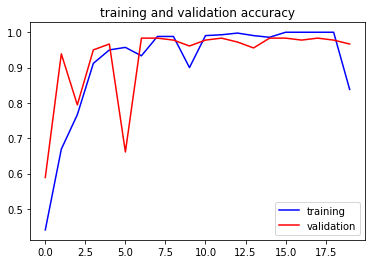

In [ ]:
acc = histoy.history['acc']
val_acc= histoy.history['val_acc']
epochs = range(len(acc))
plt.plot(epochs,acc, 'b',label='training')
plt.plot(epochs,val_acc,'r',label='validation')
plt.title('training and validation accuracy')
plt.legend()

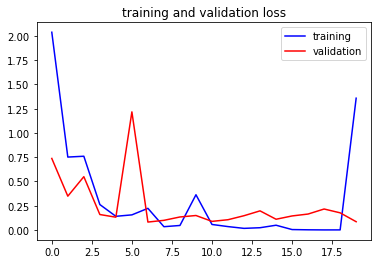

In [ ]:
loss = histoy.history['loss']
val_loss= histoy.history['val_loss']
plt.plot(epochs,loss, 'b',label='training')
plt.plot(epochs,val_loss,'r',label='validation')
plt.title('training and validation loss')
plt.legend()

In [ ]:
# Get the predictions from the model using the generator
predictions = model.predict_generator(val, steps=val.samples/val.batch_size, verbose=1)
predict_classes = np.argmax(predictions,axis=1)
errors = np.where(predict_classes!= clas)[0]
print("nombre d'erreurs est {0}/{1}".format(len(errors),val.samples))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2/2 [==============================] - 1s 424ms/step
nombre d'erreurs est 117/180


In [ ]:
errors = np.where(predict_classes!= clas)[0]
print("nombre d'erreurs est {0}/{1}".format(len(errors),val.samples))

nombre d'erreurs est 117/180


In [ ]:
clas = val.classes
labels_to_index = val.class_indices
index_to_label = dict((v,k) for k,v in labels_to_index.items()) 
print(labels_to_index)
print(index_to_label)

{'daisy': 0, 'rose': 1, 'sunflower': 2}
{0: 'daisy', 1: 'rose', 2: 'sunflower'}


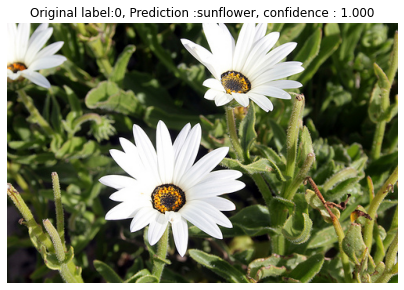

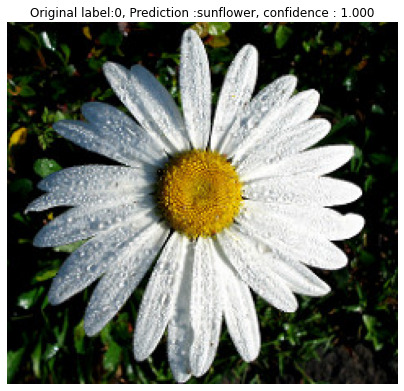

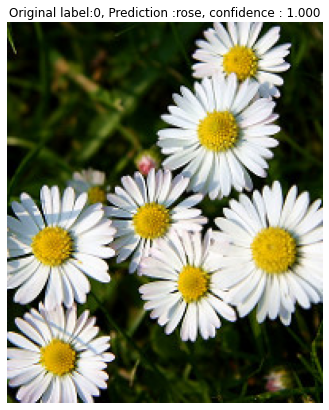

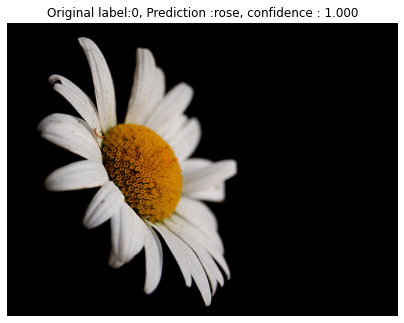

In [ ]:
for i in range(4):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = index_to_label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        clas[errors[i]],
        #fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    validation_dir='/content/drive/My Drive/Colab Notebooks/flowers/val'
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()